In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import t
import math

season_stats = pd.read_csv('Seasons_Stats.csv')

""" Filter only the relevant attributes for the research. """
players_df = season_stats[['Tm', 'Year', 'AST', 'MP', 'PTS', '3PA', '2PA', 'PER', 'G']].dropna()
TOT_mask = players_df.Tm == 'TOT'           # the sum of stats for a player that played for more than 1 team
players_df = players_df[~TOT_mask]
players_df['TbY'] = players_df.Year.astype(int).apply(lambda name: str(name)) + ' ' + players_df.Tm
print(players_df)

        Tm    Year    AST      MP     PTS   3PA     2PA   PER     G       TbY
5727   LAL  1980.0  371.0  3143.0  2034.0   1.0  1382.0  25.3  82.0  1980 LAL
5728   GSW  1980.0   87.0  1222.0   362.0   1.0   317.0  11.0  67.0  1980 GSW
5729   PHO  1980.0  322.0  2168.0  1118.0   2.0   873.0  19.2  75.0  1980 PHO
5730   BOS  1980.0  671.0  2864.0  1131.0  18.0   776.0  15.3  80.0  1980 BOS
5731   CHI  1980.0   40.0   560.0    86.0   0.0    60.0   7.4  26.0  1980 CHI
...    ...     ...    ...     ...     ...   ...     ...   ...   ...       ...
24686  CHO  2017.0   99.0  1725.0   639.0   1.0   442.0  16.7  62.0  2017 CHO
24687  BOS  2017.0   42.0   525.0   178.0   1.0   157.0  13.0  51.0  2017 BOS
24688  ORL  2017.0    4.0   108.0    23.0   0.0    31.0   7.3  19.0  2017 ORL
24689  CHI  2017.0   36.0   843.0   240.0  99.0   122.0   6.9  44.0  2017 CHI
24690  LAL  2017.0   30.0   609.0   284.0   3.0   235.0  17.0  38.0  2017 LAL

[17286 rows x 10 columns]


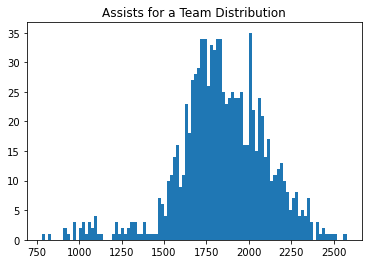

In [4]:
""" Structuring a DataFrame of aspects implying good teamwork playing style,
    indexed by team by season - TbY. """

""" AST - sum of a team assists in the season """
assists_by_team = players_df[['AST', 'TbY']].groupby(players_df.TbY).sum()
tby_mask = (players_df.groupby(players_df.TbY).count() > 13).Tm     # a team must have at least 14 players with data
plt.hist(assists_by_team[tby_mask], bins=100)
plt.title('Assists for a Team Distribution')
plt.show()

(59,)


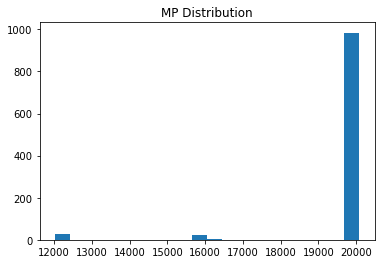

In [5]:
""" The margins of the histogram seams too large, implying errors in the data -
    therefore to remove some of the errors. """

assists_by_team = players_df[['AST', 'MP', 'TbY']].groupby(players_df.TbY).sum()
print(assists_by_team.MP[assists_by_team.MP < 18000].shape)
plt.hist(assists_by_team.MP, bins=20)
plt.title('MP Distribution')
plt.show()

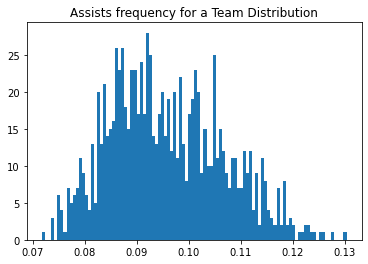

' We decided to normalize the sum of the assists by the sum of minutes played by a team,\n    measuring the frequency of assist passing in the team. '

In [6]:
# tby_mask = (tby_mask and assists_by_team.MP > 18000)
assists_by_team = assists_by_team[assists_by_team.MP > 18000]
""" Remove teams who played less than 18000 minutes, implying an error in the data. """
plt.hist(assists_by_team.AST / assists_by_team.MP, bins=100)
plt.title('Assists frequency for a Team Distribution')
plt.show()

""" We decided to normalize the sum of the assists by the sum of minutes played by a team,
    measuring the frequency of assist passing in the team. """

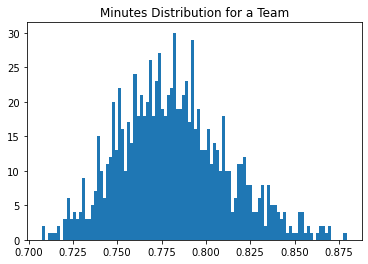

In [7]:
players_df['MpGnorm'] = players_df['MP'] / (players_df['G'] * 48)       # average minutes played per game for a player
norm_minutes_distribution = 1 - players_df[['MpGnorm', 'TbY']].groupby(players_df.TbY).std()
# The large the std => the division of minutes in the team is smaller.
plt.hist(norm_minutes_distribution[tby_mask], bins=100)
plt.title('Minutes Distribution for a Team')
plt.show()

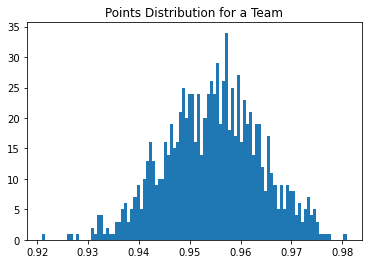

In [8]:
players_df['nPTS'] = players_df.PTS / players_df.G              # average points a game per player
points_distribution = players_df[['nPTS', 'TbY']].groupby(players_df.TbY).std()
averages_p_sum = players_df[['nPTS', 'TbY']].groupby(players_df.TbY).sum()
norm_points_distribution = 1 - (points_distribution / averages_p_sum)
# The large the std => the division of points in the team is smaller.
plt.hist(norm_points_distribution[tby_mask], bins=100)
plt.title('Points Distribution for a Team')
plt.show()

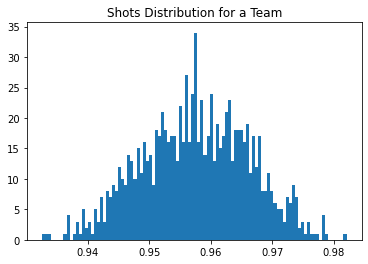

In [9]:
players_df['nPA'] = (3 * players_df['3PA'] + 2 * players_df['2PA']) / players_df.G
shots_distribution = players_df[['nPA', 'TbY']].groupby(players_df.TbY).std()
averages_s_sum = players_df[['nPA', 'TbY']].groupby(players_df.TbY).sum()
norm_shots_distribution = 1 - (shots_distribution / averages_s_sum)
# The large the std => the division of points in the team is smaller.
plt.hist(norm_shots_distribution[tby_mask], bins=100)
plt.title('Shots Distribution for a Team')
plt.show()

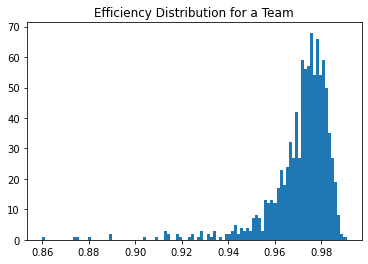

In [10]:
efficiency_distribution = players_df[['PER', 'TbY']].groupby(players_df.TbY).std()
averages_e_sum = players_df[['PER', 'TbY']].groupby(players_df.TbY).sum()

norm_efficiency_distribution = 1 - efficiency_distribution / averages_e_sum
# The large the std => the division of efficiency in the team is smaller.
plt.hist(norm_efficiency_distribution[tby_mask], bins=100)
plt.title('Efficiency Distribution for a Team')
plt.show()

In [11]:
""" Structuring a DataFrame of the measures implying good teamwork playing style. """

relevant_teams_df = pd.DataFrame({ "nED" : norm_efficiency_distribution.PER,
                                   "nSD" : norm_shots_distribution.nPA,
                                   "nPD" : norm_points_distribution.nPTS,
                                   "nMD" : norm_minutes_distribution.MpGnorm,
                                   "AST" : assists_by_team.AST / assists_by_team.MP })
relevant_teams_df = relevant_teams_df[tby_mask].dropna()
print(relevant_teams_df)

               nED       nSD       nPD       nMD       AST
TbY                                                       
1980 ATL  0.969201  0.961904  0.954720  0.840058  0.096714
1980 CHI  0.980463  0.964870  0.961019  0.823408  0.108114
1980 CLE  0.971724  0.964048  0.957545  0.802178  0.105770
1980 DEN  0.978140  0.962324  0.957515  0.803798  0.104841
1980 DET  0.984818  0.969647  0.968281  0.818747  0.098584
...            ...       ...       ...       ...       ...
2017 SAC  0.983605  0.973512  0.969454  0.866913  0.092757
2017 SAS  0.976231  0.956321  0.950867  0.822827  0.098662
2017 TOR  0.980838  0.959388  0.953479  0.806817  0.076690
2017 UTA  0.977348  0.960865  0.956754  0.809557  0.083570
2017 WAS  0.975962  0.953221  0.949576  0.766324  0.098504

[901 rows x 5 columns]


In [12]:
team_records = pd.read_csv('Team_Records.csv')
team_records = team_records[team_records.Season > '1979']

def union_star(name):
    if name.endswith('*'):
        return name[:-1]
    return name

team_records['uNAME'] = team_records.Team.apply(lambda name: union_star(name))

team_names = pd.read_csv('Team_Names.csv')

def find_team(name):
    try:
        nn = team_names[team_names.Long == name].Short
        if nn.size == 1:
            return team_names[team_names.Long == name].Short.values[0]
        return 'NOT'
    except KeyError:
        return 'NOT'

team_records['NN'] = team_records.uNAME.apply(lambda name: find_team(name))
team_records['SS'] = team_records.Season.apply(
    lambda year: year[:2] + year[-2:] if year != '1999-00' else '2000')
team_records['TbY'] = team_records.SS + ' ' + team_records.NN

trt_mask = team_records.TbY.apply(lambda ts: True if ts in relevant_teams_df.index else False)
team_records = team_records[trt_mask]

trr_mask = pd.Series(relevant_teams_df.index, index=relevant_teams_df.index).apply(
    lambda ts: True if ts in team_records.TbY.values else False
)
relevant_teams_df = relevant_teams_df[trr_mask]

print(f'We now have a matrix of teamwork measures as X in shape {relevant_teams_df.shape},\n'
      f'and a matrix of team success measures as y in shape {team_records.shape}.')

# team_names = team_names.set_index(team_names.Short).drop(columns=['Short'])
# print(team_records.Team.unique())
# print(season_stats.Tm.unique())
# pd.Series(relevant_teams_df.index).apply(lambda team: print(team_names.loc(team[5:])))

We now have a matrix of teamwork measures as X in shape (881, 5),
and a matrix of team success measures as y in shape (881, 21).


['Lost E. Conf. Finals' 'Lost E. Conf. 1st Rnd.' nan 'Lost E. Conf. Semis'
 'Lost Finals' 'Won Finals' 'Lost W. Conf. Finals'
 'Lost W. Conf. 1st Rnd.' 'Lost W. Conf. Semis']


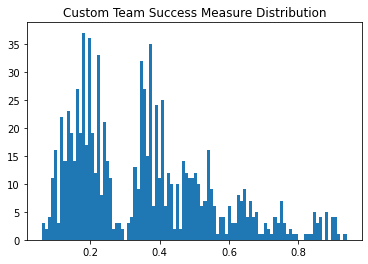

In [13]:
""" Structuring y column by giving weights to success measures - regular season and playoffs. """

print(team_records.Playoffs.unique())

playoffs_weights_dic = {np.nan : 0, 'Won Finals' : 1, 'Lost Finals' : 0.8,
                        'Lost W. Conf. Finals' : 0.6, 'Lost E. Conf. Finals': 0.6,
                        'Lost W. Conf. Semis': 0.4, 'Lost E. Conf. Semis' : 0.4,
                        'Lost W. Conf. 1st Rnd.' : 0.2, 'Lost E. Conf. 1st Rnd.' : 0.2}

team_records['PW'] = team_records.Playoffs.apply(lambda score: playoffs_weights_dic[score])
success = 0.5 * team_records['W/L%'] + 0.5 * team_records.PW
success.index = team_records.TbY

plt.hist(success, bins=100)
plt.title('Custom Team Success Measure Distribution')
plt.show()


In [14]:
" Re-arrange X matrix to fit with y column "
relevant_teams_df = relevant_teams_df.loc[success.index]

Efficiency   -0.198068
Shots        -0.420369
Points       -0.489243
Minutes      -0.349217
Assists       0.308547
dtype: float64


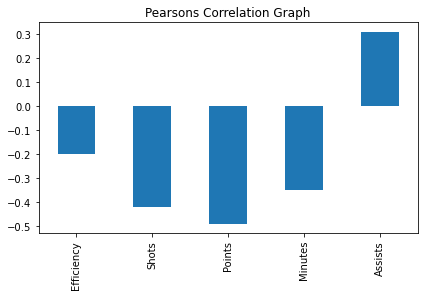

In [15]:
""" Checking the correlation of the custom success with each parameter """
correlation_series = pd.Series({"Efficiency" : stats.pearsonr(relevant_teams_df.nED, success)[0],
                                "Shots" : stats.pearsonr(relevant_teams_df.nSD, success)[0],
                                "Points" : stats.pearsonr(relevant_teams_df.nPD, success)[0],
                                "Minutes" : stats.pearsonr(relevant_teams_df.nMD, success)[0],
                                "Assists" : stats.pearsonr(relevant_teams_df.AST, success)[0]})
print(correlation_series)
correlation_series.plot(kind='bar')
plt.tight_layout()
plt.title('Pearsons Correlation Graph')
plt.show() # success

In [16]:
""" This box is an hypothesis testing try - but during the work we understood it is irrelevant for the work so
    we decided to ignore it.

upper_bound = np.mean(success) - (np.std(success) / math.sqrt(len(success)) * t.ppf(0.05, len(success) - 1))
lower_bound = np.mean(success) + (np.std(success) / math.sqrt(len(success)) * t.ppf(0.05, len(success) - 1))
columns = ["Efficiency", "Shots", "Points", "Minutes", "Assists"]
print("lower bound =", lower_bound)
print("upper bound =", upper_bound)
barlist = plt.bar(columns, abs(correlation_series.values))
for i in range(len(correlation_series.values)):
    if upper_bound < np.abs(correlation_series.values[i]) or np.abs(correlation_series.values[i]) < lower_bound:
        barlist[i].set_color('red')
        print(f"P_value with {columns[i]} is {correlation_series.values[i]} => Alternative hypothesis is rejected.")
    else:
        barlist[i].set_color('blue')
        print(f"P_value with {columns[i]} is {correlation_series.values[i]} => Alternative hypothesis is accepted.")
plt.tight_layout()
plt.plot(upper_bound, color='b')
plt.plot(lower_bound, color='b')
plt.title('Correlation Graph')
plt.show()
"""

' This box is an hypothesis testing try - but during the work we understood it is irrelevant for the work so\n    we decided to ignore it.\n\nupper_bound = np.mean(success) - (np.std(success) / math.sqrt(len(success)) * t.ppf(0.05, len(success) - 1))\nlower_bound = np.mean(success) + (np.std(success) / math.sqrt(len(success)) * t.ppf(0.05, len(success) - 1))\ncolumns = ["Efficiency", "Shots", "Points", "Minutes", "Assists"]\nprint("lower bound =", lower_bound)\nprint("upper bound =", upper_bound)\nbarlist = plt.bar(columns, abs(correlation_series.values))\nfor i in range(len(correlation_series.values)):\n    if upper_bound < np.abs(correlation_series.values[i]) or np.abs(correlation_series.values[i]) < lower_bound:\n        barlist[i].set_color(\'red\')\n        print(f"P_value with {columns[i]} is {correlation_series.values[i]} => Alternative hypothesis is rejected.")\n    else:\n        barlist[i].set_color(\'blue\')\n        print(f"P_value with {columns[i]} is {correlation_series.v

Linear Regression with Success


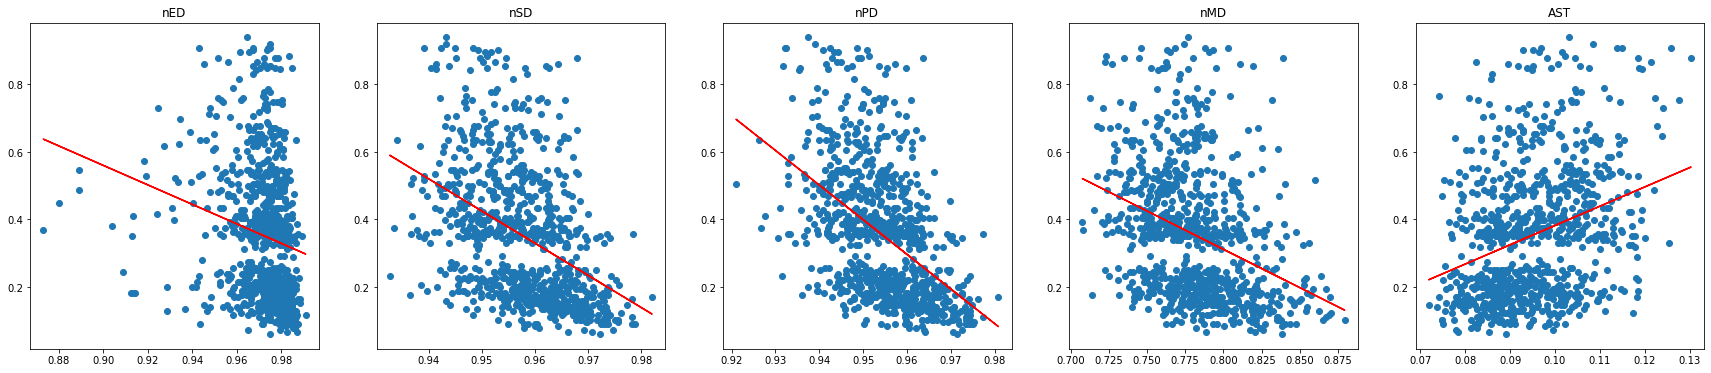

In [17]:
""" Linear Regression of each teamwork measure with success. """

plt.figure(figsize=(30, 6))
for p in range(1, 6):
    x = relevant_teams_df[relevant_teams_df.columns[p - 1]]
    y = success
    m, b = np.polyfit(x, y, 1)
    plt.subplot(1, 5, p)
    plt.scatter(x, y)
    plt.plot(x, m * x + b, color="red")
    plt.title(relevant_teams_df.columns[p - 1])
print("Linear Regression with Success")
plt.show()

In [19]:
from statsmodels.formula.api import ols

# print(relevant_teams_df.columns)
print("Each teamwork measures r-squared:")
for col in relevant_teams_df.columns:
    if col == 'success':
        continue
    linear_model = ols(f'success ~ {col}', data=relevant_teams_df).fit()
    print(f'{col}:  {linear_model.rsquared}')


Each teamwork measures r-squared:
nED:  0.03923103109120907
nSD:  0.17670994829275866
nPD:  0.23935824524359817
nMD:  0.12195227428899258
AST:  0.09520101955633908


In [20]:
""" Multi-Linear regression model for all teamwork measures with success. """
relevant_teams_df['success'] = success

linear_model = ols('success ~ nED+nSD+nPD+nMD+AST', data=relevant_teams_df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     80.65
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.19e-69
Time:                        10:25:48   Log-Likelihood:                 348.74
No. Observations:                 881   AIC:                            -685.5
Df Residuals:                     875   BIC:                            -656.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1563      0.785      7.845      0.0

In [21]:
linear_model = ols('success ~ nSD+nPD+nMD+AST', data=relevant_teams_df).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                success   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     99.97
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           4.10e-70
Time:                        10:25:49   Log-Likelihood:                 347.42
No. Observations:                 881   AIC:                            -684.8
Df Residuals:                     876   BIC:                            -660.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6990      0.710      9.430      0.0